In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import dblquad
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta
%matplotlib inline

In [2]:
data = pd.read_csv("./data/rcar/BOT_data_rcar_20170102_20170102_part0.csv")

In [3]:
data = data[(data['lat'] > 0.1) & (data['lon'] > 0.1)]

In [4]:
data["date_time"] = data["date_time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [56]:
def integrate_density(density):
    for col in range(1,density.shape[1]):
        density[0][col] += density[0][col-1];
    for row in range(1,density.shape[0]):
        density[row][0] += density[row-1][0]
        for col in range(1,density.shape[1]):
            density[row][col] += (density[row][col-1] 
                                + density[row-1][col] 
                                - density[row-1][col-1]);
                
    return density

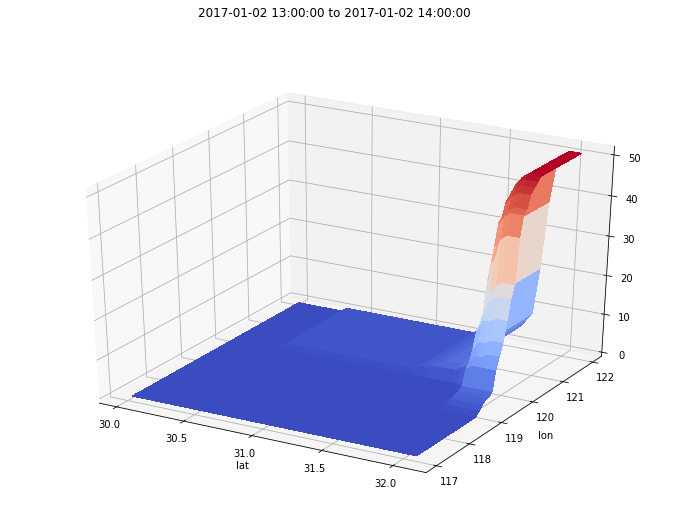

[[ 30.021 117.05 ]
 [ 30.063 117.05 ]
 [ 30.105 117.05 ]
 ...
 [ 31.995 121.95 ]
 [ 32.037 121.95 ]
 [ 32.079 121.95 ]]
[ 0.  0.  0. ... 51. 51. 51.]


In [57]:
def get_density_hour(hour_begin, hour_end):
    bins_ctr = 50
    lat_min, lat_max = 30.0, 32.1
    lon_min, lon_max = 117, 122
    x_gap = (lat_max - lat_min) / bins_ctr / 2;
    y_gap = (lon_max - lon_min) / bins_ctr / 2;
    data_hour = data[(hour_begin <= data['date_time']) & (data['date_time'] < hour_end)]
    data_hour = data_hour.drop_duplicates(['car_id'])
    # if there is only one car, code will throw error
    if data_hour.shape[0] < 2:
        return
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.gca(projection='3d')
    hist, xedges, yedges = np.histogram2d(data_hour['lat'], data_hour['lon'],
                                         bins = bins_ctr, range = [[lat_min, lat_max], [lon_min, lon_max]])
    xpos, ypos = np.meshgrid(xedges[:-1] + x_gap, yedges[:-1] + y_gap)
    hist = integrate_density(hist)
    
    ax.plot_surface(xpos, ypos, hist, cmap=cm.coolwarm, 
                    linewidth=0, antialiased=False)
    ax.set_xlabel("lat")
    ax.set_ylabel("lon")
    #ax.set_zlim(0, 2000)
    fig.suptitle("{} to {}".format(hour_begin, hour_end))
    plt.show()
    X = np.stack((xpos.flatten(), ypos.flatten()), axis=1)
    y = hist.flatten()
    return X, y

X, y= get_density_hour(datetime(2017, 1, 2, 13), datetime(2017, 1, 2, 14))
print(X)
print(y)

In [13]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from math import sqrt

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=233)

In [59]:
parameters = {'C': [0.1, 1, 10, 100],
              'gamma': [0.1, 0.2, 0.3, 0.5, 1]
             }
svr = svm.SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)
clf.best_estimator_

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [63]:
def predict_dist(clf, lat, lon):
    return clf.predict(np.array([lat, lon]).reshape(1, -1))
def get_range_density(clf, lat_min, lat_max, lon_min, lon_max):
    return (predict_dist(clf, lat_max, lon_max)
           - predict_dist(clf, lat_max, lon_min)
           - predict_dist(clf, lat_min, lon_max)
           + predict_dist(clf, lat_min, lon_min))

print(predict_dist(clf, 32, 122))
print(get_range_density(clf, 31.6, 31.7, 120, 120.1))

[40.34159275]
[0.53121818]


In [60]:
print(sqrt(mean_squared_error(y_test, clf.predict(X_test))))

2.7917820882515336
